<div dir="auto" align="center">
    <h3>
        به نام خدا
    </h3>
    <br>
    <h1>
        <strong>
            پردازش زبان‌های طبیعی
        </strong>
    </h1>
    <h2>
        <strong>
            تمرین اول
        </strong>
    </h2>
    <br>
    <h3>
        ارشان دلیلی - ٩٨١٠٥٧٥١
    </h3>
    <br>
</div>
<hr>

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
        توضیحات کلی
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این تمرین، دیالوگ‌های سریال محبوب FRIENDS را ابتدا به دست می‌آوریم و سپس تحلیل‌هایی از جمله Sentiment Analysis بر روی آن انجام می‌دهیم.
    </p>
</div>

<div>
    <h3 style='direction:rtl;text-align:justify;'> 
    پکیج‌های پیش‌نیاز
    </h3>
</div>

<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
ابتدا cellهای این قسمت را اجرا کنید تا پکیج‌های مورد نیاز نصب و ایمپورت شوند تا مطمئن  شویم در طول اجرا به مشکلی  برنمی‌خوریم.
    </p>
</div>

In [ ]:
! pip install numpy
! pip install pandas
! pip install scrapy
! pip install nltk
! pip install matplotlib
! pip install selenium
! pip install wordcloud
! pip install httplib2
! pip install yake
! pip insatll tqdm

In [1]:
# Import required packages
import re
import os
import time
import yake
import nltk
import string
import httplib2
import requests
import itertools
import numpy as np
import pandas as pd
import urllib.request
from tqdm import tqdm
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from urllib.request import urlopen
from bs4 import BeautifulSoup, SoupStrainer

<div dir='rtl'>

## دیتاست

برای به دست آوردن اسکریپت‌های سریال FRIENDS از [این سایت](https://transcripts.foreverdreaming.org/viewforum.php?f=845) استفاده می‌کنیم.
</div>

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
پیدا کردن لینک‌ها
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت لینک‌ها را به دست می‌آوریم.
    </p>
</div>

In [ ]:
def get_links(url, linkList = []):
    http = httplib2.Http()
    status, response = http.request(url)
    for link in BeautifulSoup(response, 'html.parser', parse_only=SoupStrainer('a')):
        if link.has_attr('class') and 'topictitle' in link['class'] and link.has_attr('title') and 'Thank' not in link['title']:
            sublink = link['href'][2:]
            fullLink = 'https://transcripts.foreverdreaming.org/' + sublink
            linkList.append(fullLink)
    return linkList

In [ ]:
linkList = []
url = "https://transcripts.foreverdreaming.org/viewforum.php?f=845"
linkList = get_links(url)

for index in range(25, 200, 25):
    url = f'{url}&start={index}'
    linkList = get_links(url, linkList)

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
ذخیره داده
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت داده به دست آمده را ذخیره می‌کنیم و آن‌ها را در فایل "FRIENDS_dataset.txt" قرار می‌دهیم.
    </p>
</div>


In [ ]:
def get_URL_content(URL):
    while True:
        try:
            return requests.get(URL, timeout=5).content
        except:
            pass

In [ ]:
path = 'FRIENDS_dataset'
with open(f'{path}.txt', 'w') as transcript:
    counter = 1
    for link in tqdm(linkList):
        html = get_URL_content(link)
        soup = BeautifulSoup(html, features="html.parser")
        for script in soup(["script", "style"]):
            script.extract()   
        text = soup.get_text()
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        text = '\n'.join(chunk for chunk in chunks if chunk)
        text = text.strip()
        season_num = text.strip()[:2]
        transcript.write(text)
        transcript.write("\n")
        if counter == 190:
            break
        counter += 1

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
پیش‌پردازش و جداسازی اسکریپت
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت، متن را پیش‌پردازش کرده و صحبت هر کدام از شش شخصیت اصلی را جدا می‌کنیم.
    </p>
</div>


In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

In [7]:
def modify(text):
    text = text.strip('\n')
    text = text.strip('\t')
    text = text.replace('\n','')
    text = text.replace('\t','')
    return text

In [8]:
JOEY = ''
ROSS = ''
CHANDLER = ''
MONICA = ''
PHOEBE = ''
RACHEL = ''

transcript = ""

main_characters = {}

with open('FRIENDS_dataset.txt', 'r') as f:
    for line in f.readlines():
        refined_line = re.sub(r'\([^)]*\)', '', line)
        refined_line = re.sub(r'\[[^)]*\]', '', refined_line)
        transcript += refined_line + ' '
        if refined_line.startswith("JOEY:"):
            JOEY += ' ' + (refined_line[len("JOEY") + 2:])
        elif refined_line.startswith('ROSS:'):
            ROSS += ' '+(refined_line[len("ROSS") + 2:])
        elif refined_line.startswith('CHANDLER:'):
            CHANDLER += ' '+(refined_line[len("CHANDLER") + 2:])
        elif refined_line.startswith('MONICA:'):
            MONICA += ' '+(refined_line[len("MONICA") + 2:])
        elif refined_line.startswith('PHOEBE:'):
            PHOEBE += ' '+(refined_line[len("PHOEBE") + 2:])
        elif refined_line.startswith('RACHEL:'):
            RACHEL += ' ' + (refined_line[len("RACHEL") + 2:])

    
main_characters['JOEY'] = JOEY
main_characters['ROSS'] = ROSS
main_characters['CHANDLER'] = CHANDLER
main_characters['MONICA'] = MONICA
main_characters['PHOEBE'] = PHOEBE
main_characters['RACHEL'] = RACHEL
transcript = modify(transcript)

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
نرمال‌سازی و توکنیزیشن
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت داده‌ها را tokenize می‌کنیم.
    </p>
</div>

In [9]:
def tokenize(data):
    word_tokens = word_tokenize(data)
    return word_tokens

In [10]:
stop_words = set(stopwords.words('english'))

def filter_data(data, minimum_length=1):
    word_tokens = tokenize(data)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words and len(w) > minimum_length and w not in string.punctuation: 
            filtered_sentence.append(w)
    return list(filtered_sentence)

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
تعداد کلمات و جملات هر شخصیت
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت تعداد کلمات و جملات هر کدام از شش شخصیت اصلی را به دست می‌آوریم.
    </p>
</div>


In [11]:
print("Number of all words:", len(filter_data(transcript)))
for person in main_characters:
    print("Number of " + person.capitalize() + " words:", len(filter_data(main_characters[person])))

Number of all words: 371732
Number of Joey words: 7158
Number of Ross words: 9352
Number of Chandler words: 7183
Number of Monica words: 6530
Number of Phoebe words: 6300
Number of Rachel words: 6244


In [12]:
print("Number of all sentences:", len(nltk.sent_tokenize(transcript)))
for person in main_characters:
    print("Number of " + person.capitalize() + " sentences:", len(nltk.sent_tokenize(main_characters[person])))

Number of all sentences: 84602
Number of Joey sentences: 1760
Number of Ross sentences: 2257
Number of Chandler sentences: 1654
Number of Monica sentences: 1640
Number of Phoebe sentences: 1421
Number of Rachel sentences: 1539



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت نمودار کلمات بر حسب کاراکتر را رسم می‌کنیم.
    </p>
</div>


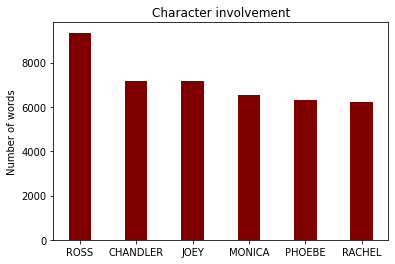

In [13]:
words_length = {}
for person in main_characters:
    words_length[person] = len(filter_data(main_characters[person]))
sorted_by_length = {k: v for k, v in sorted(words_length.items(), key=lambda item: item[1], reverse=True)}
courses = list(sorted_by_length.keys())
values = list(sorted_by_length.values())
  
fig = plt.figure()
 
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.ylabel("Number of words")
plt.title("Character involvement")
plt.show()

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
تکرار کلمات و Lemmatization
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت پرتکرارترین کلمات هر کاراکتر و هم‌چنین lemmatization آن را انجام می‌دهیم.
    </p>
</div>


In [14]:
most_common_words = {}

for person in main_characters:
    filtered_data = filter_data(main_characters[person], 3)
    dist = nltk.FreqDist(itertools.chain(w.lower() for w in filtered_data))
    most_common_words[person] = dist.most_common(10)

df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in most_common_words.items() ]))
df

,JOEY,ROSS,CHANDLER,MONICA,PHOEBE,RACHEL
0,"(yeah, 103)","(know, 173)","(well, 109)","(know, 102)","(know, 180)","(know, 131)"
1,"(know, 102)","(well, 97)","(know, 104)","(well, 59)","(like, 116)","(well, 91)"
2,"(like, 83)","(yeah, 95)","(like, 62)","(like, 57)","(yeah, 83)","(what, 81)"
3,"(what, 73)","(what, 88)","(yeah, 61)","(really, 56)","(really, 43)","(mean, 63)"
4,"(well, 68)","(like, 81)","(what, 53)","(mean, 53)","(right, 41)","(yeah, 60)"
5,"(right, 52)","(right, 64)","(right, 48)","(what, 51)","(mean, 38)","(really, 52)"
6,"(look, 45)","(think, 51)","(look, 43)","(yeah, 47)","(well, 38)","(like, 50)"
7,"(ross, 41)","(look, 50)","(think, 42)","(right, 43)","(think, 33)","(right, 50)"
8,"(come, 41)","(guys, 49)","(that, 36)","(guys, 40)","('cause, 32)","(look, 43)"
9,"(good, 41)","(mean, 46)","(joey, 32)","(think, 35)","(sorry, 32)","(think, 40)"


<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
همان‌طور که قابل مشاهده می‌باشد، تعداد زیادی از کلمات پرتکرار صفت می‌باشند. در این قسمت پرتکرارترین کلمات که نام می‌باشند را برای هر شخصیت به دست می‌آوریم.
    </p>
</div>


In [15]:
most_common_NN_words = {}

lemma = nltk.WordNetLemmatizer()
lemmatized_words = {}

for person in main_characters:
    filtered_data = filter_data(main_characters[person], 3)
    lemmatized_words[person] = [lemma.lemmatize(t) for t in filtered_data]
    lemmatized_tokens = []
    for tag in nltk.pos_tag(lemmatized_words[person]):
        if tag[1].startswith('NN'):
            lemmatized_tokens.append(tag[0])
    dist = nltk.FreqDist(itertools.chain(token.lower() for token in lemmatized_tokens))
    most_common_NN_words[person] = dist.most_common(10)
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in most_common_NN_words.items() ]))
df

,JOEY,ROSS,CHANDLER,MONICA,PHOEBE,RACHEL
0,"(yeah, 92)","(yeah, 82)","(well, 86)","(yeah, 42)","(yeah, 67)","(well, 59)"
1,"(well, 49)","(well, 67)","(yeah, 52)","(well, 40)","(okay, 25)","(yeah, 51)"
2,"(ross, 41)","(thing, 51)","(look, 33)","(ross, 31)","(sorry, 23)","(ross, 38)"
3,"(look, 33)","(look, 44)","(joey, 32)","(thing, 31)","(guy, 19)","(look, 34)"
4,"(chandler, 28)","(guy, 42)","(thing, 30)","(guy, 31)","(time, 18)","(guy, 27)"
5,"(alright, 24)","(carol, 38)","(time, 27)","(time, 29)","(look, 18)","(okay, 26)"
6,"(thing, 22)","(rachel, 34)","(guy, 25)","(alright, 28)","(thing, 18)","(monica, 25)"
7,"(time, 21)","(time, 34)","(alright, 22)","(joey, 26)","(well, 18)","(sorry, 24)"
8,"(woman, 20)","(julie, 27)","(woman, 22)","(look, 26)","(ross, 17)","(thing, 23)"
9,"(come, 19)","(alright, 26)","(mean, 21)","(rachel, 25)","(know, 17)","(mean, 22)"


<div>
    <h3 style='direction:rtl;text-align:justify;'>  
کلمات کلیدی
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در الین قسمت با استفاده از کتاب‌خانه yake کلمات کلیدی هر شخصیت را به دست می‌آوریم.
    </p>
</div>


In [16]:
keyword_extractor = yake.KeywordExtractor(lan="en", n=3, dedupLim=0.9, top=10, features=None)
keywords = {}

for person in main_characters:
    temp = keyword_extractor.extract_keywords(main_characters[person])
    rounded_element = []
    for element in temp:
        rounded_element.append((element[0], round(element[1], 7)))
    keywords[person] = rounded_element

df = pd.DataFrame(keywords)
df

,JOEY,ROSS,CHANDLER,MONICA,PHOEBE,RACHEL
0,"(hey, 0.0015572)","(hey, 0.0017614)","(Hey, 0.0027543)","(gonna, 0.0031858)","(yeah, 0.0019586)","(God, 0.0019746)"
1,"(Yeah, 0.0019875)","(Yeah, 0.0019084)","(Yeah, 0.0034706)","(God, 0.0039819)","(gonna, 0.0049591)","(yeah, 0.003523)"
2,"(Ross, 0.0039779)","(gonna, 0.0035338)","(gonna, 0.0046768)","(guys, 0.0047621)","(god, 0.0060277)","(gonna, 0.0037533)"
3,"(guy, 0.0073412)","(Carol, 0.004279)","(Joey, 0.0062866)","(Yeah, 0.0052356)","(Hey, 0.0067087)","(Ross, 0.0042601)"
4,"(Chandler, 0.0075902)","(guys, 0.0044437)","(guys, 0.0086661)","(guy, 0.0065684)","(Ooh, 0.0083916)","(guys, 0.0064597)"
5,"(good, 0.0076976)","(Carol Carol Carol, 0.0046261)","(man, 0.0087221)","(Ross, 0.0067276)","(good, 0.0112187)","(Hey, 0.0088991)"
6,"(gonna, 0.0091562)","(Rachel, 0.0051493)","(Guy, 0.0090128)","(Joey, 0.0085596)","(guys, 0.0113367)","(Monica, 0.0097633)"
7,"(Alright, 0.0093205)","(thing, 0.0068332)","(good, 0.0113332)","(Rachel, 0.0093339)","(guy, 0.0118765)","(guy, 0.0115594)"
8,"(man, 0.0111296)","(Julie, 0.0079038)","(Alright, 0.0120444)","(Hey, 0.0102674)","(Ross, 0.0149103)","(good, 0.013476)"
9,"(guys, 0.0139096)","(alright, 0.0079565)","(Janice, 0.0132586)","(Alright, 0.0108332)","(wanna, 0.0196559)","(God Monica, 0.0148896)"


<div>
    <h3 style='direction:rtl;text-align:justify;'>  
تحلیل Sentiment
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت، sentimet analysis را با استفاده از SentimentIntensityAnalyzer انجام می‌دهیم و صحبت‌های هر شخصیت را به مثبت، خنثی و منفی تقسیم می‌کنیم.
    </p>
</div>


In [17]:
speeches = {}
for person in lemmatized_words:
    words = ""
    for word in lemmatized_words[person]:
        words += word.lower() + ' '
    speeches[person] = words

In [18]:
sia = SentimentIntensityAnalyzer()
sentiments = {}
for person, speech in speeches.items():
    status = sia.polarity_scores(speech)
    sentiments[person] = [status['pos'], status['neu'], status['neg']]

In [19]:
df = pd.DataFrame(data=sentiments)
df.index = ['positive', 'neutral', 'negative']
df

,JOEY,ROSS,CHANDLER,MONICA,PHOEBE,RACHEL
positive,0.308,0.309,0.324,0.330,0.378,0.289
neutral,0.609,0.611,0.551,0.546,0.516,0.608
negative,0.083,0.081,0.125,0.124,0.106,0.103


<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
حال نمودار sentiment شخصیت‌های اصلی را رسم می‌کنیم.
    </p>
</div>

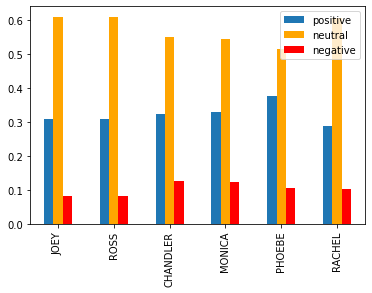

In [20]:
df.transpose().plot(kind='bar',color=[ "tab:blue", "orange", "r"])
plt.show()

<div>
    <h3 style='direction:rtl;text-align:justify;'>  
مثبت‌ترین و منفی‌ترین شخصیت
    </h3>
</div>



<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در این قسمت با توجه به نتایج قسمت قبل، مثبت‌ترین فرد و منفی‌ترین فرد را از بین شش شخصیت اصلی سریال انتخاب می‌کنیم.
    </p>
</div>


In [21]:
positively_sorted = {k: v for k, v in sorted(sentiments.items(), key=lambda item: item[1][0], reverse=True)}
negatively_sorted = {k: v for k, v in sorted(sentiments.items(), key=lambda item: item[1][2], reverse=True)}
print(f"Most positive character: {list(positively_sorted.keys())[0].capitalize()}\nMost negative character: {list(negatively_sorted.keys())[0].capitalize()}")

Most positive character: Phoebe
Most negative character: Chandler


<div dir="auto" align="justify">
    <p style='direction:rtl;text-align:justify;'>
در نهایت نیز پای چارت را برای sentiment analysis برای شش کاراکتر اصلی سریال رسم می‌کنیم.
    </p>
</div>


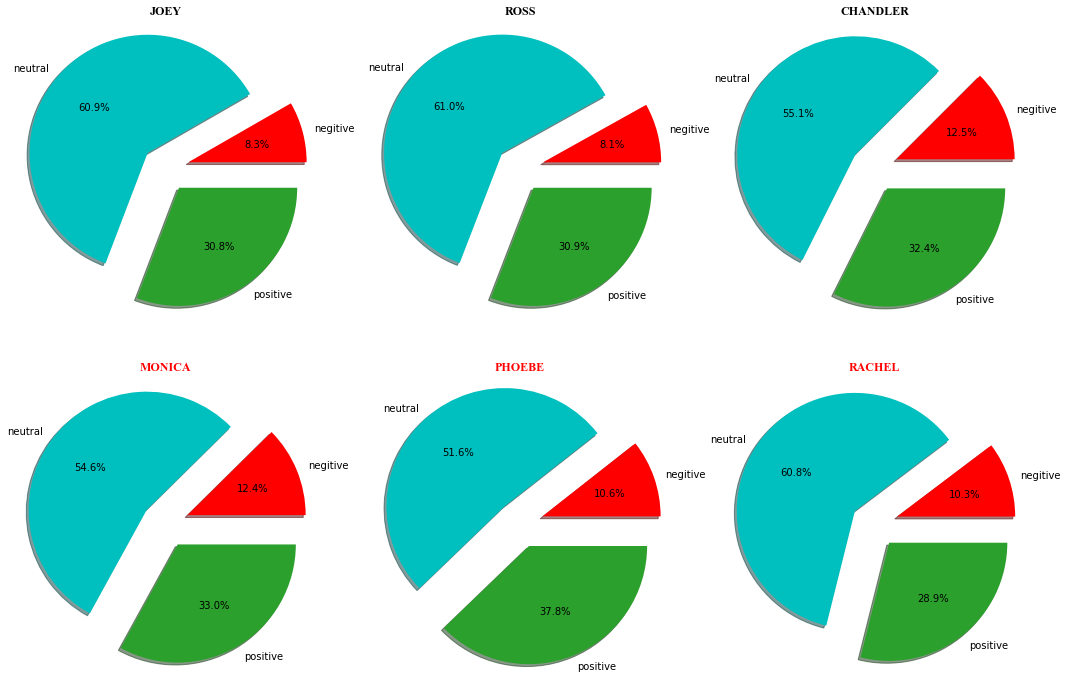

In [22]:
figure, axis = plt.subplots(2, 3)
figure.set_size_inches(18,12)
colors = ['tab:green', 'c', 'r']
labels = ['positive', 'neutral', 'negitive']
explode = (0.2, 0.2, 0.2)

axis[0, 0].pie(df.JOEY, colors=colors, labels=labels, explode=explode, autopct='%1.1f%%', counterclock=False, shadow=True)
axis[0, 0].set_title('JOEY', fontname="Times New Roman", fontweight="bold")

axis[0, 1].pie(df.ROSS, colors=colors, labels=labels, explode=explode, autopct='%1.1f%%', counterclock=False, shadow=True)
axis[0, 1].set_title('ROSS', fontname="Times New Roman", fontweight="bold")

axis[0, 2].pie(df.CHANDLER, colors=colors, labels=labels, explode=explode, autopct='%1.1f%%', counterclock=False, shadow=True)
axis[0, 2].set_title('CHANDLER', fontname="Times New Roman", fontweight="bold")

axis[1, 0].pie(df.MONICA, colors=colors, labels=labels, explode=explode, autopct='%1.1f%%', counterclock=False, shadow=True)
axis[1, 0].set_title('MONICA', fontname="Times New Roman", fontweight="bold", color="r")

axis[1, 1].pie(df.PHOEBE, colors=colors, labels=labels, explode=explode, autopct='%1.1f%%', counterclock=False, shadow=True)
axis[1, 1].set_title('PHOEBE', fontname="Times New Roman", fontweight="bold", color="r")

axis[1, 2].pie(df.RACHEL, colors=colors, labels=labels, explode=explode, autopct='%1.1f%%', counterclock=False, shadow=True)
axis[1, 2].set_title('RACHEL', fontname="Times New Roman", fontweight="bold", color="r")


plt.show()